In [1]:
import numpy as np
import os
from my_rigid_kinematics import dh_robot_config
from JS_control import cacl_torque
import matplotlib.pyplot as plt
from pyrep import PyRep
from arm import CtRobot
from pyrep.backend import vrep
import sympy as sp
from pyrep.const import JointMode
import time

%matplotlib notebook

pr = PyRep()

In [2]:
param = ['D', 'a', 'alpha', 'theta', 'num_joints', 'jointType', 'Tbase', 'L', 'M']
config = dict()
for i in range(len(param)):
    config[param[i]] = np.load('./robot_config/config_ct_7DOF/%s.npy'%param[i])

In [3]:
robot = dh_robot_config(int(config['num_joints']), config['alpha'], config['theta'], config['D'], config['a'], 
                                                config['jointType'], config['Tbase'], config['L'], config['M'])
robot.initKinematicTransforms()

Calculating link 0
Calculating link 1
Calculating link 2
Calculating link 3
Calculating link 4
Calculating link 5
Calculating link 6
Calculating link 7
Calculating Mass and Gravity Matrix...
-------------------------------------------------------------------
Calculation complete


## Simulation Set up

In [13]:
robot._J_link[0](2,4,1,3,.3,.1,.1,0,0,0)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [24]:
pr.launch(os.getcwd() + '/Modified_DH_ct_7DOF.ttt', headless=False)
ct_robot = CtRobot()

xyz = np.array([0, 0, 0])

In [ ]:
# Set up joints to be in force control mode
for i in range(ct_robot._num_joints):
    ct_robot.joints[i].set_joint_mode(JointMode.FORCE)
    ct_robot.joints[i].set_control_loop_enabled(False)
for j in range(1, ct_robot._num_joints + 1):
    ct_robot.arms[i].set_dynamic(True)
ct_robot.arms[0].set_dynamic(False)


In [ ]:
# Set up joints to be in force control mode
for i in range(ct_robot._num_joints):
    ct_robot.joints[i].set_joint_mode(JointMode.PASSIVE)
    ct_robot.joints[i].set_control_loop_enabled(False)
for j in range(1, ct_robot._num_joints + 1):
    ct_robot.arms[i].set_dynamic(False)
ct_robot.arms[0].set_dynamic(False)

ct_robot.joints[4].set_joint_mode(JointMode.FORCE)
ct_robot.arms[4].set_dynamic(True)

In [ ]:
# Starting simulation
pr.start()
err_pos = []
err_vel = []
mespos = []
depos = []

# Desired trajectory
dt = 0.01
end_time = 4
t_dic = np.linspace(0, end_time, num=int(end_time/dt), endpoint=True)
t = sp.Symbol('t')
# disired trajectory of position for each joint

# # Sine wave activation
# traj = [
#     0.0*sp.sin(t*4),
#     0.0*sp.cos(t*4),
#     (0/180*np.pi)*sp.sin(t*np.pi),
#     (0/180*np.pi)*sp.sin(t*4),
#     (30/180*np.pi)*sp.cos(t*4),
#     (0/180*np.pi)*sp.cos(t*4),
#     0.00*sp.sin(t/2)
# ]

# Step response
traj = [
    0.000 * sp.ones(1),
    0.000 * sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    (30/180*np.pi)*sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    0.00*sp.ones(1)
]

pos = [sp.lambdify(t, i) for i in traj]
vel = [sp.lambdify(t, i.diff(t)) for i in traj]
acc = [sp.lambdify(t, i.diff(t).diff(t)) for i in traj]

# Gain
kp = np.diag([0, 0, 0, 0, 0.1, 0, 0])
kv = np.diag([0, 0, 0, 0, 0, 0, 0])

# Simulation
for i in range(int(end_time/dt)):
#     ts = time.time()
    posd = np.array([j(t_dic[i]) for j in pos]).squeeze()
    veld = np.array([j(t_dic[i]) for j in vel]).squeeze()
    accd = np.array([j(t_dic[i]) for j in acc]).squeeze()
    posm = np.array(ct_robot.get_joint_positions())
    velm = np.array(ct_robot.get_joint_velocities())
    tau = cacl_torque(robot, kp, kv, posd, posm, veld, velm, xyz, accd)
    # print('Time for computing torque: %.4f'%(time.time()-ts))
    print(tau)
    ct_robot.set_joint_target_velocities((np.sign(tau)*1000000).tolist())
    ct_robot.set_joint_forces(np.abs(tau).tolist())
    pr.step()
#     ts = time.time()
    measure_pos = np.array(ct_robot.get_joint_positions())
    measure_vel = np.array(ct_robot.get_joint_velocities())
#     print('Time for Interacting with V-REP: %.4f'%(time.time()-ts))
    
    # Record error of each joint
    err_pos.append(posd - measure_pos)
    err_vel.append(veld - measure_vel)
    depos.append(posd)
    mespos.append(measure_pos)


[ 1.43275261e-05 -6.35241303e-06 -1.03770502e-02  9.04556016e-02
 -2.53020782e-07 -1.35011278e-02  0.00000000e+00]
[ 1.43275774e-05 -6.35594985e-06 -1.03776717e-02  9.04549826e-02
 -8.72463678e-07 -1.35014732e-02  1.72762152e-11]
[ 1.43275004e-05 -6.35064467e-06 -1.03767419e-02  9.04559111e-02
  5.66923474e-08 -1.35009551e-02 -8.63787561e-12]
[ 1.43275132e-05 -6.35152880e-06 -1.03768961e-02  9.04557564e-02
 -9.81547295e-08 -1.35010415e-02 -4.31920242e-12]
[ 1.43274747e-05 -6.34887619e-06 -1.03764294e-02  9.04562207e-02
  3.66425045e-07 -1.35007824e-02 -1.72762969e-11]
[ 1.43275646e-05 -6.35506585e-06 -1.03775145e-02  9.04551373e-02
 -7.17638931e-07 -1.35013869e-02  1.29581648e-11]
[ 1.43275004e-05 -6.35064446e-06 -1.03767395e-02  9.04559112e-02
  5.67291650e-08 -1.35009551e-02 -8.63890242e-12]
[ 1.43274747e-05 -6.34887598e-06 -1.03764276e-02  9.04562207e-02
  3.66462949e-07 -1.35007824e-02 -1.72773540e-11]
[ 1.43275646e-05 -6.35506585e-06 -1.03775127e-02  9.04551374e-02
 -7.17638930e-0

In [17]:
# Change Unit
err_pos = np.array(err_pos)
err_pos[:, 0:1] = err_pos[:, 0:1]*1000
err_pos[:, 1:2] = err_pos[:, 1:2]*1000
err_pos[:, 6:7] = err_pos[:, 6:7]*1000
err_pos[:, 2:3] = err_pos[:, 2:3]*180/np.pi
err_pos[:, 3:4] = err_pos[:, 3:4]*180/np.pi
err_pos[:, 4:5] = err_pos[:, 4:5]*180/np.pi
err_pos[:, 5:6] = err_pos[:, 5:6]*180/np.pi
mespos = np.array(mespos)
depos = np.array(depos)

<IPython.core.display.Javascript object>


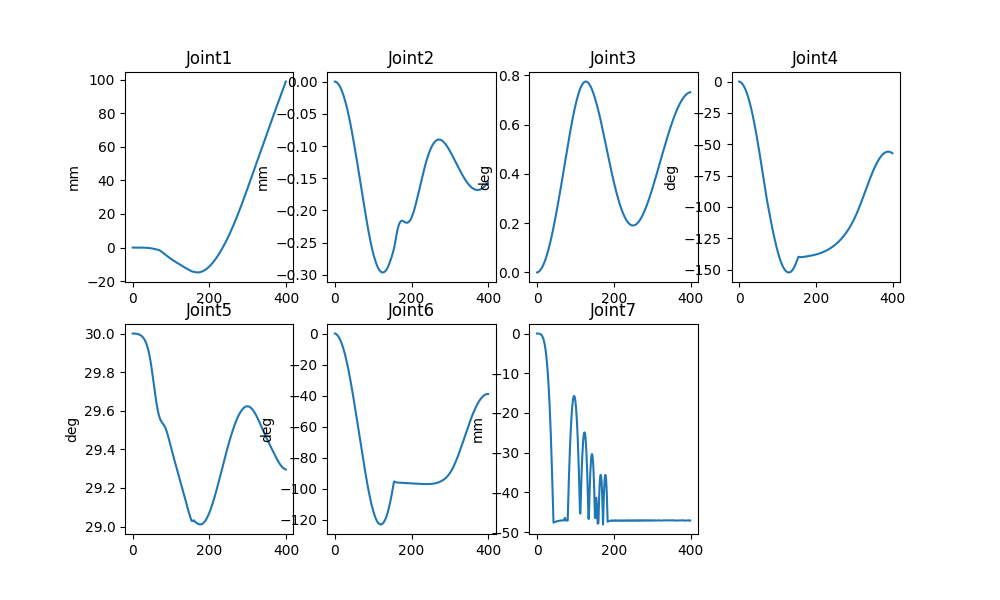

In [18]:
# Plot error of position from joint to joint
plt.figure(figsize=(10,6))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')

<IPython.core.display.Javascript object>


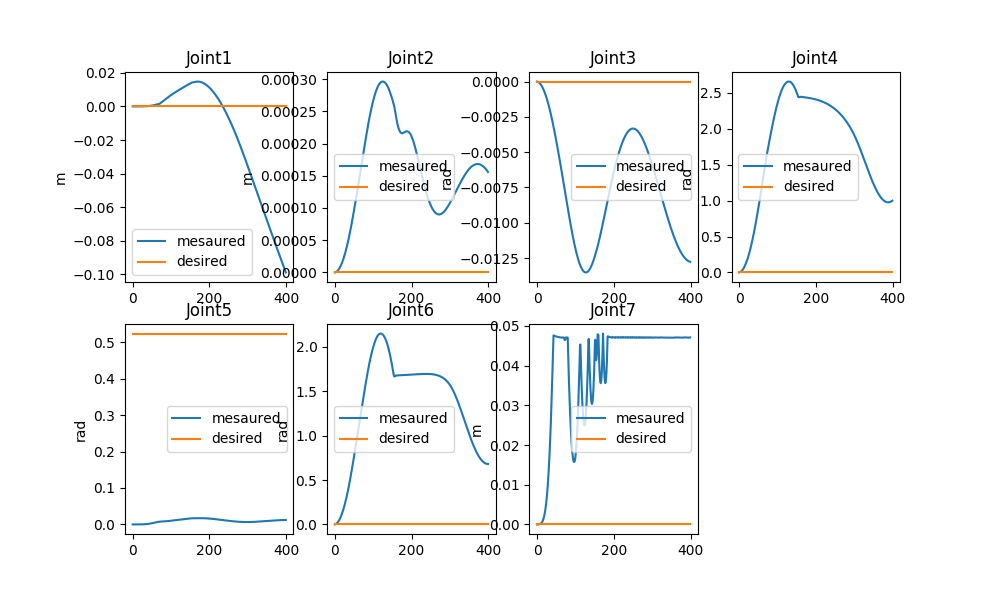

In [22]:
# Plot error of position from joint to joint
plt.figure(figsize=(10,6))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(mespos[:, i], label='mesaured')
    plt.plot(depos[:, i], label='desired')
    plt.legend()
    if i in [0,1,6]:
        plt.ylabel('m')
    else:
        plt.ylabel('rad')


In [15]:
pr.stop()

In [23]:
pr.shutdown()